In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/INTERRUPCAO_CARGA.csv", sep=";")
df.head()

,cod_perturbacao,din_interrupcaocarga,id_subsistema,nom_subsistema,id_estado,nom_agente,val_cargainterrompida_mw,val_tempomedio_minutos,val_energianaosuprida_mwh,flg_envolveuredebasica,flg_envolveuredeoperacao
0,0413/2007,2007-01-01 13:25:00,NE,NORDESTE,BA,NEOENERGIA COELBA,73.00,59.0,71.783333,S,S
1,0414/2007,2007-01-02 00:19:00,N,NORTE,MA,EQUATORIAL MARANHAO,1.80,9.0,0.270000,S,S
2,0385/2007,2007-01-03 18:02:00,SE,SUDESTE/CENTRO-OESTE,GO,EQUATORIAL GOIÁS,16.57,6.0,1.657000,S,S
3,0390/2007,2007-01-04 22:22:00,SE,SUDESTE/CENTRO-OESTE,GO,EQUATORIAL GOIÁS,7.60,2.0,0.253333,N,S
4,0419/2007,2007-01-06 06:26:00,NE,NORDESTE,PE,NEOENERGIA PE,35.00,12.0,7.000000,S,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8005 entries, 0 to 8004
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cod_perturbacao            8005 non-null   object 
 1   din_interrupcaocarga       8005 non-null   object 
 2   id_subsistema              8005 non-null   object 
 3   nom_subsistema             8005 non-null   object 
 4   id_estado                  8005 non-null   object 
 5   nom_agente                 8005 non-null   object 
 6   val_cargainterrompida_mw   8005 non-null   float64
 7   val_tempomedio_minutos     8005 non-null   float64
 8   val_energianaosuprida_mwh  8005 non-null   float64
 9   flg_envolveuredebasica     8005 non-null   object 
 10  flg_envolveuredeoperacao   8005 non-null   object 
dtypes: float64(3), object(8)
memory usage: 688.1+ KB


In [4]:
# Converter a coluna de data para o formato datetime do pandas
df['timestamp'] = pd.to_datetime(df['din_interrupcaocarga'])

# Filtrar o dataset para manter apenas os eventos de Goiás
df_goias = df[df['id_estado'] == 'GO'].copy()

# Definir o timestamp como o índice do DataFrame para facilitar a agregação
df_goias.set_index('timestamp', inplace=True)

In [5]:
# A variável mais importante é a 'val_energianaosuprida_mwh'
# Vamos agregar os dados por dia ('D'), somando a energia não suprida de todos os eventos que ocorreram no mesmo dia.
deficit_diario = df_goias['val_energianaosuprida_mwh'].resample('D').sum()

# O resample cria todos os dias no intervalo. Dias sem eventos terão o valor NaN (Not a Number).
# Devemos preencher esses dias com 0, pois um dia sem evento é um dia com déficit zero.
deficit_diario = deficit_diario.fillna(0)

# Converter para um DataFrame para facilitar a manipulação
df_diario = deficit_diario.to_frame(name='deficit_diario_mwh')

print("Tabela de déficit diário para Goiás:")
display(df_diario.head())

Tabela de déficit diário para Goiás:


,deficit_diario_mwh
timestamp,
2007-01-03,1.657000
2007-01-04,0.253333
2007-01-05,0.000000
2007-01-06,0.000000
2007-01-07,0.253333


In [6]:
# Calcular os limites apenas nos dias em que HOUVE algum déficit
dias_com_deficit = df_diario[df_diario['deficit_diario_mwh'] > 0]

# Limite para Risco Alto: Percentil 99 (o 1% pior dos eventos)
limite_alto = dias_com_deficit['deficit_diario_mwh'].quantile(0.99)

# Limite para Risco Médio: Percentil 95 (os 5% piores dos eventos)
limite_medio = dias_com_deficit['deficit_diario_mwh'].quantile(0.95)

print(f"Limite para Risco Médio (P95): {limite_medio:.2f} MWh")
print(f"Limite para Risco Alto (P99): {limite_alto:.2f} MWh")


# Função para aplicar a classificação
def classificar_risco(deficit):
    if deficit >= limite_alto:
        return 'alto'
    elif deficit >= limite_medio:
        return 'medio'
    else:
        # Dias com déficit zero ou pequeno são classificados como 'baixo'
        return 'baixo'

# Criar a coluna final da nossa variável alvo
df_diario['nivel_risco'] = df_diario['deficit_diario_mwh'].apply(classificar_risco)

Limite para Risco Médio (P95): 161.73 MWh
Limite para Risco Alto (P99): 464.22 MWh


## Desbalanceamento da classe

Os dados são muito desbalanceados, sendo a maioria dos níveis de risco baixos.

Distribuição das classes de risco:
nivel_risco
baixo    6789
medio      30
alto        8
Name: count, dtype: int64


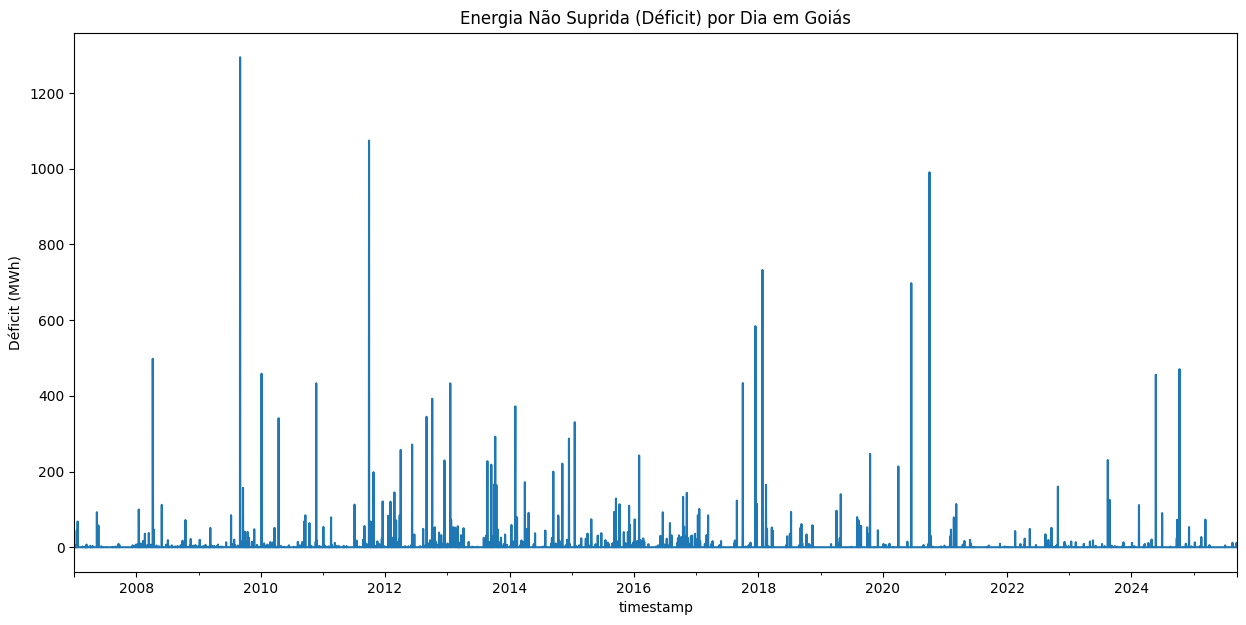

In [7]:
# Verificar a distribuição das classes de risco
print("Distribuição das classes de risco:")
print(df_diario['nivel_risco'].value_counts())

# Plotar os déficits diários para visualizar os eventos
plt.figure(figsize=(15,7))
plt.title('Energia Não Suprida (Déficit) por Dia em Goiás')
df_diario['deficit_diario_mwh'].plot()
plt.ylabel('Déficit (MWh)')
plt.show()

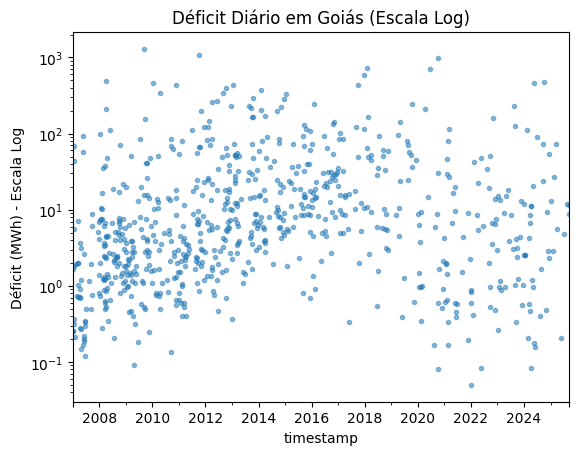

In [8]:
# Adicionar este código para um novo gráfico
plt.figure()
plt.title('Déficit Diário em Goiás (Escala Log)')
ax = df_diario['deficit_diario_mwh'].plot(logy=True, style='.', alpha=0.5)
ax.set_ylabel("Déficit (MWh) - Escala Log")
plt.show()

In [10]:
# Adicionar no final do notebook
output_path = '../data/processed/target_variable_daily.parquet'
df_diario.to_parquet(output_path)
print(f"DataFrame final salvo em: {output_path}")

DataFrame final salvo em: ../data/processed/target_variable_daily.parquet
